In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import bacco

npart = 512
boxsize = 1000.

bacco.configuration.update({'pk':{'boltzmann_solver': 'CLASS'}})
bacco.configuration.update({'pknbody' : {'ngrid'  :  npart}})
bacco.configuration.update({'scaling' : {'disp_ngrid' : npart}})

# CREATE A ZA SIMULATION

In [3]:
Omega0 = 0.3175
OmegaLambda = 0.6825
OmegaBaryon = 0.049
HubbleParam = 0.6711
sigma8 = 0.834
ns = 0.9624
expfactor = 1.

pars_arr = np.array([Omega0, OmegaBaryon, HubbleParam, ns, sigma8])

pars = {'omega_cdm':Omega0-OmegaBaryon,'omega_de':OmegaLambda, 'omega_baryon':OmegaBaryon, 'hubble':HubbleParam, 
        'neutrino_mass':0.0, 'sigma8':sigma8, 'ns':ns, 'expfactor':expfactor}
cosmo = bacco.Cosmology(**pars) #bacco.Cosmology(**bacco.cosmo_parameters.Planck13)  
print(cosmo)

sim, disp_field = bacco.utils.create_lpt_simulation(cosmo, boxsize, Nmesh=npart, Seed=1915,
                                                    FixedInitialAmplitude=False,InitialPhase=0, 
                                                    expfactor=1, LPT_order=1, order_by_order=None,
                                                    phase_type=1, ngenic_phases=True, return_disp=True, 
                                                    sphere_mode=0)

2024-01-31 18:20:36,614 bacco.cosmo :    initialization took 0.000 secs
2024-01-31 18:20:36,615 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
2024-01-31 18:20:36,616 bacco.sims : Initialising simulation Default
2024-01-31 18:20:36,617 bacco.sims : ...done in 0.00106 s


-----------------------------------------------
Cosmology "Default", de_model "LCDM" 
- Paramerers: Omega_cdm = 0.2685, Omega_b = 0.049, Omega_de = 0.6825, 
Hubble=0.6711, Sigma_8=0.834, A_s=None, ns=0.9624, neutrino_mass=0.0, 
Omega_r=0.0, Omega_k=0.0, tau=0.0952, w0=-1, wa=0
- Power Spectrum: CLASS,   Expansion Factor: 1.0,   ReNormalizeInputSpectrum: True
-----------------------------------------------


2024-01-31 18:20:36,993 bacco.cosmo :    computed CLASS power spectrum at z=0.00 in 0.301 secs
2024-01-31 18:20:36,993 bacco.cosmo :    created Pk(z=0) tab from k 0.0006710999999999999 to 100000.0 h/Mpc
2024-01-31 18:20:46,698 bacco.cosmo :    computed CLASS power spectrum at z=0.00 in 0.286 secs
2024-01-31 18:20:46,746 bacco.cosmo :    created Pk(z=0) tab from k 0.0006710999999999999 to 100000.0 h/Mpc
2024-01-31 18:20:53,247 bacco.scaler : Adding displacement field with a vel-factor=52.941596


# SAVE DATA

In [4]:
np.save('ZA_disp.npy', disp_field,allow_pickle=True)
np.save('lin_field.npy', sim.linear_field[0],allow_pickle=True)
np.savetxt('cosmo_pars.txt', pars_arr.T)

2024-01-31 18:22:07,480 bacco.sims : Generating linear field: Di=1.0
2024-01-31 18:22:07,786 bacco.cosmo :    computed CLASS power spectrum at z=0.00 in 0.304 secs
2024-01-31 18:22:07,827 bacco.cosmo :    created Pk(z=0) tab from k 0.0006710999999999999 to 100000.0 h/Mpc


## Let's check the data

### ZA Displacement

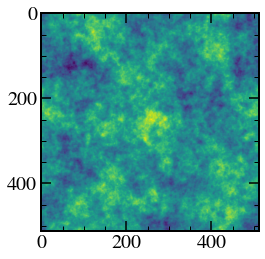

In [6]:
plt.imshow(disp_field[0,0,:,:])
plt.show()

### Linear density

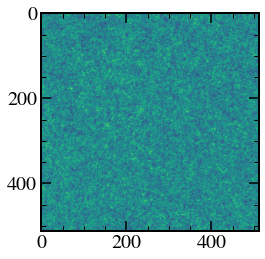

In [7]:
plt.imshow(sim.linear_field[0,0,:,:])
plt.show()

# Now, run map2map with

python m2m.py test --test-in-patterns "ZA_disp.npy" --test-tgt-patterns "ZA_disp.npy" --in-norms "cosmology.dis" --tgt-norms "cosmology.dis" --crop 128 --crop-step 128 --pad 48 --model d2d.StyledVNet --batches 1 --loader-workers 7 --load-state "map2map/weights/d2d_weights.pt" --callback-at "." --test-style-pattern "cosmo_pars.txt"

# Now we read the output (usually called ._out.npy ... I know, crazy!) and move some regular grid particles to their emulated positions

In [12]:
pred_disp = np.load('._out.npy')


grid = bacco.visualization.uniform_grid(npix=npart, L=boxsize, ndim=3, bounds=False)

pred_pos = bacco.scaler.add_displacement(None,
                             pred_disp,
                             box=boxsize,
                             pos=grid.reshape(-1,3),
                             vel=None,
                             vel_factor=0,
                             verbose=True)[0]

density = bacco.statistics.compute_mesh(ngrid=npart, box=boxsize, pos=pred_pos,
                              deposit_method='cic',
                              interlacing=False)

2024-01-31 18:52:27,109 bacco.scaler : Adding displacement field with a vel-factor=0.000000
2024-01-31 18:52:27,999 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-01-31 18:52:28,002 bacco.statistics : starting deposit 1
2024-01-31 18:52:28,791 bacco.statistics :  mesh done in 0.792 s


### Non-linear positions

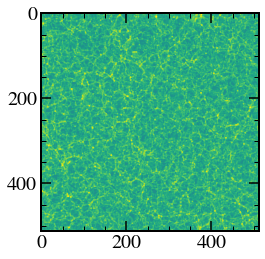

In [16]:
 # Set normalisation
from matplotlib.colors import SymLogNorm
norm = SymLogNorm(linthresh=0.1, linscale=0.1, vmin=-100.0, vmax=100.0)

plt.imshow(density[0,0,:,:], norm=norm)
plt.show()